In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline
plt.style.use('ggplot')
orders = pd.read_csv('requirements.csv', index_col='req_id', dtype={'req_id':'int32', 
                                                               'user_id':'int32',
                                                               'eval_set':'category', 
                                                               'assigned_team_no':'int8', 
                                                               'request_hour_of_day':'int8', #could also be category
                                                               'days_since_prior_request':'float16'})
revisions = pd.read_csv('Revision1.csv', index_col='revision_id', dtype={'revision_id':'int32', 
                                                                   'revision_no':'object', 
                                                                   'update_id':'int16', 
                                                                   'testing_id':'int16'})
order_revisions_train = pd.read_csv('products__train.csv', dtype={'req_id':'int32',
                                                                                     'revision_id':'int32',
                                                                                     'code_pushed_live_environment':'int8',
                                                                                     'remodified':'uint8'})
order_revisions_prior = pd.read_csv('products__prior.csv', dtype={'order_id':'int32',
                                                                                     'revision_id':'int32',
                                                                                     'code_pushed_live_environment':'int8',
                                                                                     'remodified':'uint8'})
updates = pd.read_csv('update.csv', index_col='update_id', 
                     dtype={'update_id':'int16', 'update':'category'})
tests = pd.read_csv('testing.csv', index_col='testing_id', 
                          dtype={'testing_id':'int8', 'test':'category'})

C:\Users\ummag\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [11]:
display(revisions.head())

revision_no  update_id  testing_id
revision_id                                   
1             Revision1         61          19
2             Revision2        104          13
3             Revision3         94           7
4             Revision4         38           1
5             Revision5          5          13

In [12]:
temp = pd.merge(left=revisions,
         right=order_revisions_train.revision_id.value_counts().to_frame('count'), 
         left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                    right=pd.DataFrame(order_revisions_train.groupby('revision_id').remodified.sum().to_frame(), dtype='int64'),  
                    left_index=True, right_index=True)

temp['remodified_rate'] = temp['remodified']/temp['count']

temp = pd.merge(left=temp, 
                right=order_revisions_train.groupby('revision_id').code_pushed_live_environment.mean().to_frame('add_to_cart_mean'),
                left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                right=pd.merge(left=order_revisions_train, 
                               right=orders[['assigned_team_no', 'request_hour_of_day', 'days_since_prior_request']], 
                               left_on='req_id', right_index=True).groupby('revision_id').assigned_team_no.mean().to_frame(),
                left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                right=pd.merge(left=order_revisions_train, 
                               right=orders[['assigned_team_no', 'request_hour_of_day', 'days_since_prior_request']], 
                               left_on='req_id', right_index=True).groupby('revision_id').request_hour_of_day.mean().to_frame(),
                left_index=True, right_index=True)

temp = pd.merge(left=temp, 
                right=pd.merge(left=order_revisions_train, 
                               right=orders[['assigned_team_no', 'request_hour_of_day', 'days_since_prior_request']], 
                               left_on='req_id', right_index=True).groupby('revision_id').days_since_prior_request.mean().to_frame(),
                left_index=True, right_index=True)
display(temp.head())
temp.shape

revision_no  update_id  testing_id  count  remodified  remodified_rate  \
1   Revision1         61          19     55          37         0.672727   
2   Revision2        104          13      3           1         0.333333   
3   Revision3         94           7      5           5         1.000000   
4   Revision4         38           1     19          12         0.631579   
8   Revision8        116           1     11           6         0.545455   

   add_to_cart_mean  assigned_team_no  request_hour_of_day  \
1          6.472727          3.416667            11.916667   
2         15.333333          1.666667            15.000000   
3          2.800000          6.000000            13.000000   
4          8.789474          3.428571            15.142857   
8         10.636364          4.000000            10.666667   

   days_since_prior_request  
1                 19.546875  
2                  8.000000  
3                 20.000000  
4                 19.000000  
8                 18.328125

(26253, 10)

In [13]:
temp = temp[temp['count'] > 10]
temp.shape

(11409, 10)

In [14]:
temp.drop(['revision_no', 'testing_id', 'update_id', 'remodified'], axis=1, inplace=True)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
temp_scaled = scaler.fit_transform(temp)
print('done.')

done.


C:\Users\ummag\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ummag\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float16, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [16]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(15,10))
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata


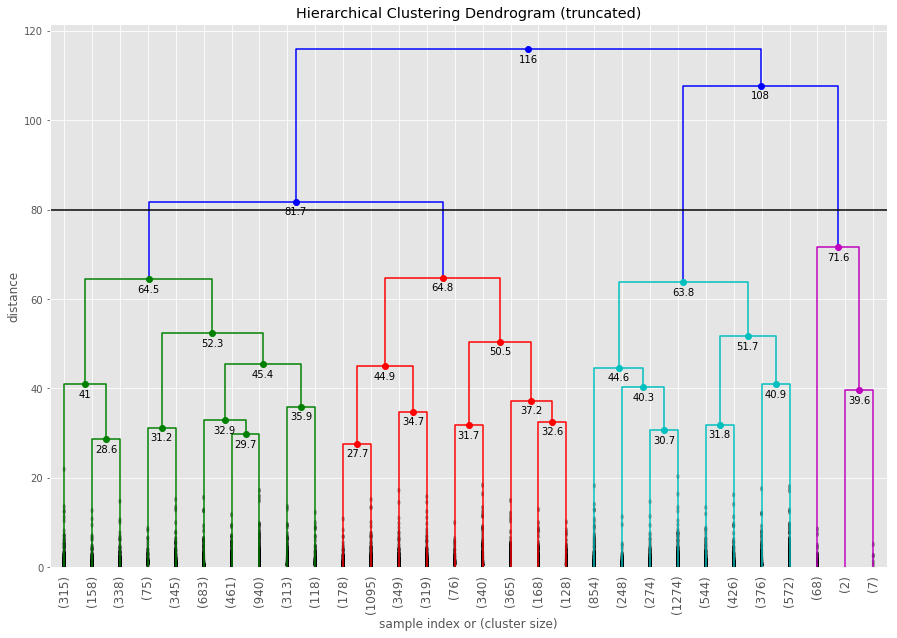

In [17]:
from scipy.cluster.hierarchy import dendrogram, ward

linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=80
)

plt.show()

In [18]:
print('distances for the last 5 merges:\n{}'.format(linked_array[-5:,2]))

distances for the last 5 merges:
[ 64.78650936  71.64342127  81.72494696 107.68141861 115.81316747]


In [19]:
from scipy.cluster.hierarchy import fcluster
max_d = 80
clusters = fcluster(linked_array, max_d, criterion='distance')
    
labels, counts = np.unique(clusters, return_counts=True)

temp['clusters'] = clusters

print('remodified rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('rr: {}'.format(round(temp[temp['clusters'] == i].remodified_rate.mean()*100, 2))) 

remodified rates for each cluster


label: 1
n: 3746
rr: 41.01

label: 2
n: 3018
rr: 49.07

label: 3
n: 4568
rr: 63.51

label: 4
n: 77
rr: 71.0


In [20]:
label = 3
print('remodified rate for cluster {0}: {1}'.format(label, round(temp[temp['clusters'] == label].remodified_rate.mean()*100,2)))
pd.merge(right=temp[temp['clusters'] == label], left=revisions, left_index=True, right_index=True).head()

remodified rate for cluster 3: 63.51


revision_no  update_id  testing_id  count  remodified_rate  \
1    Revision1         61          19     55         0.672727   
4    Revision4         38           1     19         0.631579   
10  Revision10        115           7     94         0.585106   
34  Revision34        121          14    188         0.638298   
45  Revision45         83           4    451         0.696231   

    add_to_cart_mean  assigned_team_no  request_hour_of_day  \
1           6.472727          3.416667            11.916667   
4           8.789474          3.428571            15.142857   
10          8.606383          1.909091            15.045455   
34          9.531915          2.765625            13.046875   
45          8.170732          2.557252            13.335878   

    days_since_prior_request  clusters  
1                  19.546875         3  
4                  19.000000         3  
10                 14.820312         3  
34                 17.015625         3  
45                 18.250000         3

In [21]:
temp.drop('clusters', axis=1, inplace=True)

from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
temp_robust = robust_scaler.fit_transform(temp)

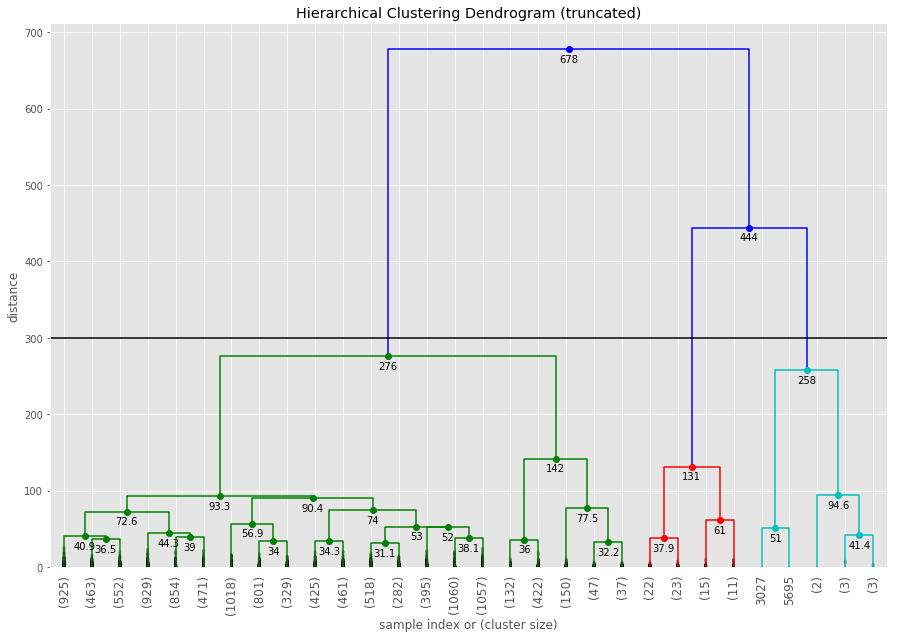

In [22]:
linked_array = ward(temp_robust)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=300
)

plt.show()

In [23]:
from scipy.cluster.hierarchy import fcluster
max_d = 300
clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

temp['clusters'] = clusters

print('remodified rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('rr: {}'.format(round(temp[temp['clusters'] == i].remodified_rate.mean()*100, 2)))


remodified rates for each cluster


label: 1
n: 11328
rr: 52.22

label: 2
n: 71
rr: 69.32

label: 3
n: 10
rr: 79.72


In [24]:
temp_scaled = scaler.fit_transform(temp[['count', 'remodified_rate']])
print('done.')

done.


C:\Users\ummag\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ummag\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


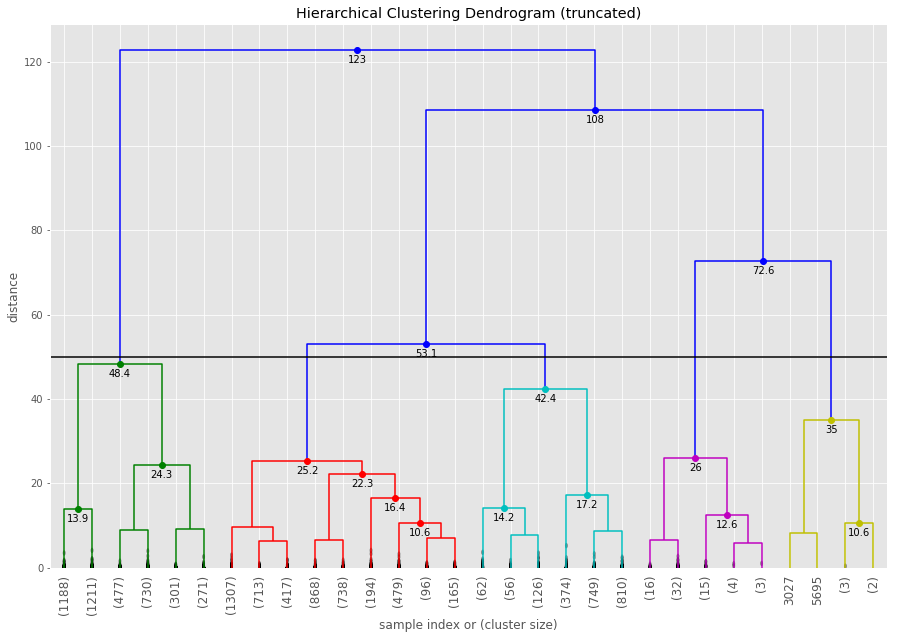

In [25]:
linked_array = ward(temp_scaled)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=50
)
plt.show()

In [26]:
max_d = 50
clusters = fcluster(linked_array, max_d, criterion='distance')

labels, counts = np.unique(clusters, return_counts=True)

temp['clusters'] = clusters

print('remodified rates for each cluster\n')
for i in range(1,len(np.unique(clusters))+1):
    print('\nlabel: {}'.format(i))
    print('n: {}'.format(counts[i-1]))
    print('rr: {}'.format(round(temp[temp['clusters'] == i].remodified_rate.mean()*100, 2)))


remodified rates for each cluster


label: 1
n: 4178
rr: 33.94

label: 2
n: 4977
rr: 57.85

label: 3
n: 2177
rr: 74.47

label: 4
n: 70
rr: 69.88

label: 5
n: 7
rr: 82.16
